# Анализ вариантов увеличения выручки интернет-магазина и проведенного A/B-теста

Для анализа представлены сведения о коммерческой деятельности крупного интернет-магазина. Анализ будет проводиться на основе данных из следующих датасетов: 

1.  описание гипотез и различные их показатели, такие как охват пользователей, их влияние на пользователей, уверенность в гипотезе, затраты ресурсов на проверку гипотезы;

2. сведения о заказах по группам A/B-теста;

3. сведения о количестве пользователей в указанную дату по группам A/B-теста.

В начале работы будет произведена предобработка данных, заключающаяся в приведении данных к стандартному виду, преобразование форматов данных при необходдимости, поиск и удаление дубликатов при их наличии. Поиск и удаление аномалий будет осуществлен в разрезе перцентилей в блоке по анализу A/B-теста.

Для анализа представлено 9 гипотез о мерах по увеличения выручки магазина. Будет произведена их приоритизация с выявлением наиболее перспективной. 

Далее будет произведено исследование результатов запущенного A/B-теста и дана оценка необходимости либо ее отсутствию в реализации гипотетических мероприятий в всязи с наличием/отсутсивем положительных изменений в контрольной группе. 

### Загрука данных и их подготовка к анализу

In [1]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import matplotlib.ticker
from datetime import datetime as dt, timedelta
import numpy as np
from pandas.plotting import register_matplotlib_converters
import warnings
register_matplotlib_converters()
import scipy.stats as stats
pd.set_option("max_colwidth", 100)

In [2]:
hypothesis = pd.read_csv('/....csv')
orders = pd.read_csv('/...s.csv')
visitors = pd.read_csv('/....csv')

#### Предобработака данных таблицы hypothesis

In [3]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
hypothesis.columns = ['hypothesis', 'reach', 'impact', 'confidence', 'efforts']

#### Предобработака данных таблицы orders

In [6]:
display(orders.head())
orders.tail()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,transactionId,visitorId,date,revenue,group
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A
1196,3936777065,2108080724,2019-08-15,202740,B


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

In [9]:
orders['date'] = pd.to_datetime(orders['date'])

In [11]:
orders.duplicated().sum()

0

In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


#### Предобработака данных таблицы visitors

In [13]:
display(visitors.head())
visitors.tail()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


,date,group,visitors
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490
61,2019-08-31,B,718


In [14]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [15]:
visitors['date'] = pd.to_datetime(visitors['date'])

In [16]:
visitors.duplicated().sum()

0

In [17]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


#### Изучение тестируемых групп

In [18]:
print(f'Общее количество наблюдений в тесте - {orders.shape[0]}')
print(f'Количество уникальных пользователей по двум группам - {orders["visitor_id"].nunique()}')

Общее количество наблюдений в тесте - 1197
Количество уникальных пользователей по двум группам - 1031


In [19]:
ordersA = orders.query('group == "A"')
print(f'Количество наблюдений в группе А - {ordersA.shape[0]}')
print(f'Количество уникальных пользователей в группе - {ordersA["visitor_id"].nunique()}')

Количество наблюдений в группе А - 557
Количество уникальных пользователей в группе - 503


In [20]:
ordersB = orders.query('group == "B"')
print(f'Количество наблюдений в группе В - {ordersB.shape[0]}')
print(f'Количество уникальных пользователей в группе - {ordersB["visitor_id"].nunique()}')

Количество наблюдений в группе В - 640
Количество уникальных пользователей в группе - 586


In [21]:
print(f'Разница в количестве наблюдений между группами составляет {round((ordersB.shape[0]-ordersA.shape[0])/ordersB.shape[0]*100, 2)} %')
print(f'Разница в количестве уникальных пользователей между группами составляет {round((ordersB["visitor_id"].nunique()-ordersA["visitor_id"].nunique())/ordersB["visitor_id"].nunique()*100, 2)} %')

Разница в количестве наблюдений между группами составляет 12.97 %
Разница в количестве уникальных пользователей между группами составляет 14.16 %


In [22]:
ordersAB = ordersA.merge(ordersB, on='visitor_id')
print(f'Количество наблюдений, присутствующих сразу в двух группах - {ordersAB.shape[0]}')
print(f'Количество уникальных пользователей, присутствующих сразу в двух группах - {ordersAB["visitor_id"].nunique()}')

Количество наблюдений, присутствующих сразу в двух группах - 183
Количество уникальных пользователей, присутствующих сразу в двух группах - 58


Таким образом, изучив структуру пользователей, можно сделать вывод о том, что количество как наблюдений, так и уникальных пользователей различно между группами А и В, разница составляет 12.97 и 14.16 % соответственно. Поскольку данное различие не столь критично, оставим его без изменений. Также имеется 183 наблюдения (58 уникальных пользователей), присутствующих в обеих группах сразу, однако, во-первых, это также не столь большое количество, а во-вторых, непонятен критерий выбора для удаления пользователя из одной из групп, поэтому данные пользователи также будут участвовать в дальнейшем тестировании.

**Таким образом, стандартная предобработка данных произведена, общая информация о них проанализирована, данные приведены к соответствующим форматам, дублирующих записей в них не обнаружено, произведен анализ структуры данных в разрезе проводимого А/В-теста, можно приступать к следующему этапу исследования** 

### Приоритизация гипотез

In [23]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [24]:
hypothesis['ICE']=round(hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts'], 2)

In [25]:
hypothesis.sort_values(by='ICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


In [26]:
hypothesis['RICE']=round(hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts'], 2)

In [27]:
hypothesis.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


Итак, анализ гипотез во фреймворке ICE на первое место вывел гипотезу о запуске акции, дающей скидку на товар в День рождения, при анализе же по RICE лидером стала гипотеза о добавлении формы подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок. Причиной подобной расстановки гипотез во втором случае стало то, что гипотеза о проведении акции в День рождения пользователя имеет наименьший показатель по обхвату пользователей, что и привело к снижению ее приоритета во фреймворке RICE

### Анализ A/B-теста

#### График кумулятивной выручки по группам

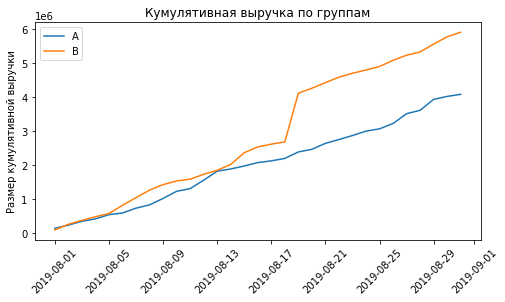

In [28]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
fig = plt.figure(figsize=[8,4])
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xticks(rotation=45)
plt.title('Кумулятивная выручка по группам')
plt.ylabel('Размер кумулятивной выручки')
plt.legend();

In [29]:
orders.sort_values(by='revenue', ascending=False).head(10)

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
858,192721366,1316129916,2019-08-27,93940,A
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
682,1216533772,4266935830,2019-08-29,78990,B
662,1811671147,4266935830,2019-08-29,78990,A
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A


Представленный график наглядно демонстрирует, что кумулятивная выручка в группе В стабильно больше, нежели в группе А, более того во второй половине тестируемого периода эта разность стала еще более существенной. Также имеет место резкий скачок кумулятивной выручки в группе В, произошедший в районе 19.08.2019 г., с большей долей вероятности он связан с наличием аномально высокого заказа в это день в указанной группе, проверка этого утверждения будет произведена в лальнейшем анализе

#### График кумулятивного среднего чека по группам

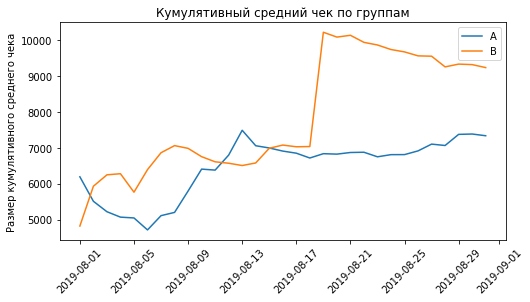

In [30]:
fig = plt.figure(figsize=[8,4])
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=45)
plt.title('Кумулятивный средний чек по группам')
plt.ylabel('Размер кумулятивного среднего чека')
plt.legend();

По показателю среднего чека в тестируемом периоде группа В также лидирует. Здесь наблюдается резкий скачок показателя в группе А 13.08.2019, также наблюдается резкий скачок показателя в группе В примерно 19.08.2019, возможно это связано с наличием аномальных значений в групах, данный факт будет проверен далее

#### График относительного изменения кумулятивного среднего чека группы B к группе A

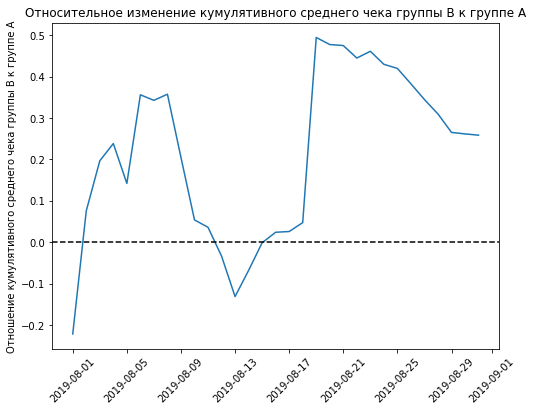

In [31]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][
    ['date', 'revenue', 'orders']
]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][
    ['date', 'revenue', 'orders']
]

mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
fig = plt.figure(figsize=[8,6])
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.xticks(rotation=45)
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.ylabel('Отношение кумулятивного среднего чека группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--');

Относительные показатели также соответствуют абсолютным - средний чек в группе В больше чека группы А (за исключением момента с возможным наличием аномального значения)

#### График кумулятивного среднего количества заказов на посетителя по группам

In [32]:
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


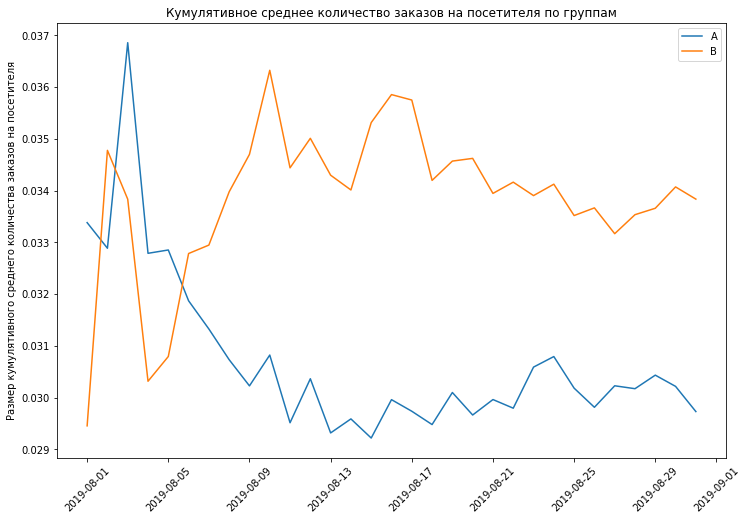

In [33]:
cumulativevisitorsA = cumulativeData[cumulativeData['group']=='A'][['date','visitors', 'orders']]
cumulativevisitorsB = cumulativeData[cumulativeData['group']=='B'][['date','visitors', 'orders']]

fig = plt.figure(figsize=[12,8])
plt.plot(cumulativevisitorsA['date'], cumulativevisitorsA['orders']/cumulativevisitorsA['visitors'], label='A')
plt.plot(cumulativevisitorsB['date'], cumulativevisitorsB['orders']/cumulativevisitorsB['visitors'], label='B')
plt.xticks(rotation=45)
plt.title('Кумулятивное среднее количество заказов на посетителя по группам')
plt.ylabel('Размер кумулятивного среднего количества заказов на посетителя')
plt.legend();

По данному параметру показатели в группе В также существенно выше, нежели показатели группы А, имеют место резкие колебания значений в начале проведения теста, однако они, наверняка, также обусловлены наличием аномальных значений

#### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

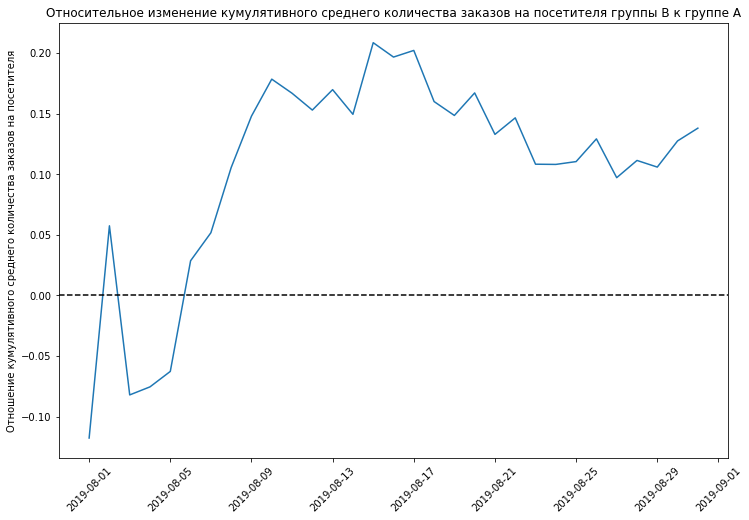

In [34]:
mergedCumulativevisitors = cumulativevisitorsA.merge(cumulativevisitorsB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
fig = plt.figure(figsize=[12,8])
plt.plot(mergedCumulativevisitors['date'], (mergedCumulativevisitors['ordersB']/mergedCumulativevisitors['visitorsB'])/(mergedCumulativevisitors['ordersA']/mergedCumulativevisitors['visitorsA'])-1)
plt.xticks(rotation=45)
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.ylabel('Отношение кумулятивного среднего количества заказов на посетителя')
plt.axhline(y=0, color='black', linestyle='--');

Относительные значения наглядно показывают, что количество заказов на пользователя в группе В выше, чем в группе А

#### Точечный график количества заказов по пользователям

      visitor_id  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
...          ...     ...
359   1484903144       1
360   1485964287       1
361   1494664757       1
362   1495112755       1
1030  4283872382       1

[1031 rows x 2 columns]


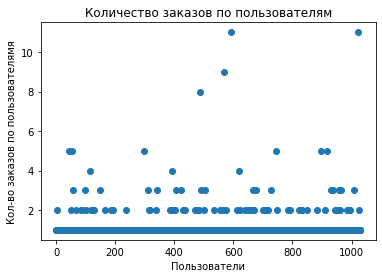

In [35]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['visitor_id', 'orders']
print(ordersByUsers.sort_values(by='orders', ascending=False))
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Количество заказов по пользователям')
plt.ylabel('Кол-во заказов по пользователямя')
plt.xlabel('Пользователи');

Представленный выше график наглядно демонстрирует то, что большинство пользователей совершают всего 1 заказ

#### 95-й и 99-й перцентили количества заказов на пользователя

In [36]:
np.percentile(ordersByUsers['orders'], [90, 95, 99])

array([1., 2., 4.])

Анализ перцентилей также подтверждает, что 95 % пользователей совершают не более 2 заказов, поэтому именно это значение установим в качестве пограничного для выявления "аномальных" пользователей

#### Точечный график стоимостей заказов

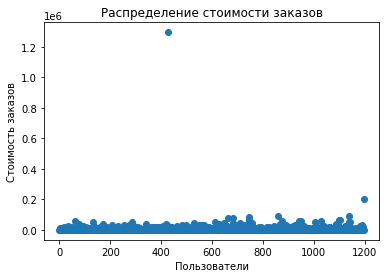

In [37]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Распределение стоимости заказов')
plt.ylabel('Стоимость заказов')
plt.xlabel('Пользователи');

Рассмотрим график в более приближенном варианте:

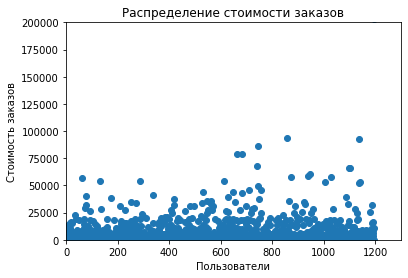

In [38]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Распределение стоимости заказов')
plt.ylabel('Стоимость заказов')
plt.axis([0, 1300, 0, 200000])
plt.xlabel('Пользователи');

Представленный график наглядно демонстрирует то, что большинство пользователей совершают покупки на сумму, не превышающую 100 000

#### 95-й и 99-й перцентили стоимости заказов

In [39]:
np.percentile(orders['revenue'], [90, 95, 99])

array([18168. , 28000. , 58233.2])

In [40]:
orders_max_revenue = orders.loc[orders['revenue']>58233.2].sort_values(by='revenue')
orders_max_revenue

,transaction_id,visitor_id,date,revenue,group
940,2420050534,4003628586,2019-08-08,58550,B
949,1347999392,887908475,2019-08-21,60450,A
1099,316924019,148427295,2019-08-12,65710,A
1103,1348774318,1164614297,2019-08-12,66350,A
743,3603576309,4133034833,2019-08-09,67990,A
662,1811671147,4266935830,2019-08-29,78990,A
682,1216533772,4266935830,2019-08-29,78990,B
744,3668308183,888512513,2019-08-27,86620,B
1136,666610489,1307669133,2019-08-13,92550,A
858,192721366,1316129916,2019-08-27,93940,A


Анализ перцентилей также подтверждает, что не менее 95 % пользователей совершают заказы на свумму не более 28 000, поэтому именно это значение установим в качестве пограничного для выявления "аномальных" пользователей.

Отфильтрованная по мтоимости таблица также показывает, что действительно в обеих группах присутствуют "выбросы", и в группе А как раз 13.08.2019 совершен заказ на сумму, сильно выше большинства прочих значений в ней - 93 940, а в группе В как раз 19.08.2019 также совершен очень крупный заказ на сумму 1 294 500, что и привело к таким резким скачкам на графиках, поэтому далее будет выявлено, сохранятся ли представленные выше тенденции при устранении аномальных значений в группах

**Итак, теперь необходимо выяснить, насколько существенны различия в показателях среднего количества заказов на посетителя и среднего чека заказа по группам со статистической точки зрения.
Для оценки значимости различий будет использован непараметрический тест Уилкоксона-Манна-Уитни.
Уровень значимости alpha определим в размере 0.05**

#### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Для начала проверим следующие гипотезы:

Н0: Разница в среднем количестве заказов на посетителя между группами статистически не значима, вывод о различии сделать нельзя

Н1: Разница в среднем количестве заказов на посетителя между группами статистически значима, различия между группами существенны

In [41]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'visitor_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'visitor_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders'] 
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value: {0:.3f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительное различие в среднем количестве заказов на посетителя между группами: {0:.3f}'.format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.017
Относительное различие в среднем количестве заказов на посетителя между группами: 0.138


Итак, расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным показал, что различия имеются и они достаточно существенны - 13,8 % (то есть гипотеза Н0 о том, что разница в среднем количестве заказов на посетителя между группами статистически не значима, вывод о различии сделать нельзя, отклоняется ввиду того, что p-значение (p-value), равное 0.017, меньше установленного уровня значимости - 0.05)

#### Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

Далее проверим следующие гипотезы:

Н0: Разница в среднем чеке заказа между группами статистически не значима, вывод о различии сделать нельзя

Н1: Разница в среднем чеке заказа на посетителя между группами статистически значима, различия между группами существенны

In [42]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Oтносительный прирост среднего чека группы B по отношению к группе А: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.729
Oтносительный прирост среднего чека группы B по отношению к группе А: 0.259


А вот по показателю среднего чека картина складываеся совсем иная: несмотря на относительную разницу между группами в почти 26%, большое значение p-value характеризует данное различие как несущественное (Н0 отклонить невозможно)

#### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

In [43]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] >2]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] >2]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormalUsers

1099     148427295
18       199603092
928      204675465
23       237748145
37       249864742
           ...    
723     4009017467
627     4120364173
743     4133034833
499     4256040402
662     4266935830
Name: visitor_id, Length: 74, dtype: int64

**Таким образом, данные будут очищены о  выбросов по значениям 95-ого перцентиля**

Теперь проверим гипотезы на основе очищенных от аномалий данных:

Н0: Разница в среднем количестве заказов на посетителя между группами статистически не значима, вывод о различии сделать нельзя

Н1: Разница в среднем количестве заказов на посетителя между группами статистически значима, различия между группами существенны

In [44]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

print('Относительное различие в среднем количестве заказов на посетителя между группами: {0:.3f}'.format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

p-value: 0.013
Относительное различие в среднем количестве заказов на посетителя между группами: 0.173


Итак, расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по "очищенным" данным вывел примерно те же значения, что и по "сырым": различия между группами имеются и они достаточно существенны (размер p-value в 0.013 меньше уровня занчимости в 0.05, поэтому и здесь гипотеза Н0 отклоняется, а альтернативная гипотеза принимается) 

#### Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

Далее проверим гипотезы относительно среднего чека по очищенным от аномалий данным:

Н0: Разница в среднем чеке заказа между группами статистически не значима, вывод о различии сделать нельзя

Н1: Разница в среднем чеке заказа на посетителя между группами статистически значима, различия между группами существенны

In [45]:
print(
    'p-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers))
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers))
                )
            ]['revenue']
        )[1]
    )
)
print(
    "Oтносительный прирост среднего чека группы B по отношению к группе А: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers))
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers))
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value: 0.738
Oтносительный прирост среднего чека группы B по отношению к группе А: -0.020


По очищенным от аномалий данным по показателю среднего чека картина складываеся аналогично даным "сырым": снова большое значение p-value (существенно выше уровня значимости в 0.05) характеризует различие между группами как несущественное, то есть принимается гипотеза Н0

#### Вывод по результатам теста

Итак, результаты проведенного А/В-теста можно подытожить следующими выводами:

- если говорить про абсолютные показатели, то здесть группа В значительно опережает группу А по всем показателям, таким как кумулятивная выручка и кумулятивный средний чек, кумулятивное среднее количество заказов на посетителя;

- если рассматривать результаты  различия показателей групп с точки зрения статистическо значимости, расчет статистической значимости различий в среднем количестве заказов на посетителя между группами как по «сырым», так и по отфильтрованным без аномалий данным показал, что различия между группами имеются и они достаточно существенны - 13,8 % (абсолютные показатели по группе В выше, чем в группе А), по показателю же среднего чека как по "сырым", так и по отфильтрованным данным, где в абсолютных показателях также лидировала группа В, статистический тест характеризует различие между группами как несущественное.

Таким образом, по результатам проведенного теста лидирующие позиции по всем показателям имеет группа В, так что можно с уверенностью говорить о том, что внедрение исследуемых мероприятий наверняка даст свой положительный результат. И так как в целом тест длился уже достаточно долгое количество времени, и во второй половине исследуемого периода его показатели по группам, судя по представленным графикам, стабилизировались, то продолжать дальнейшее тестирование не имеет под собой рациональных оснований. Поэтому тест необходимо остановить и признать победу группы В